In [1]:
import numpy as np
import os
import glob as gb
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

#### THIS ALL CODE "https://www.kaggle.com/code/hossamfakher/ct-heart-binary-segmentation"

In [2]:
TRAIN_PATH ='../input/ct-heart-segmentation/data/train/'
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
X_train=[]
Y_train=[]
for folder in tqdm(os.listdir(TRAIN_PATH)):
    files=gb.glob(TRAIN_PATH+folder+'/image/*.png')
    for file in files :
        img =cv2.imread(file,0)
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) 
        X_train.append(list(img)) 
    files=gb.glob(TRAIN_PATH+folder+'/mask/*.png')
    for file in files :
        img =cv2.imread(file,0)
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) 
        Y_train.append(list(img)) 

100%|██████████| 19/19 [00:21<00:00,  1.11s/it]


In [3]:
X_train=np.array(X_train)
Y_train=np.array(Y_train,np.bool)

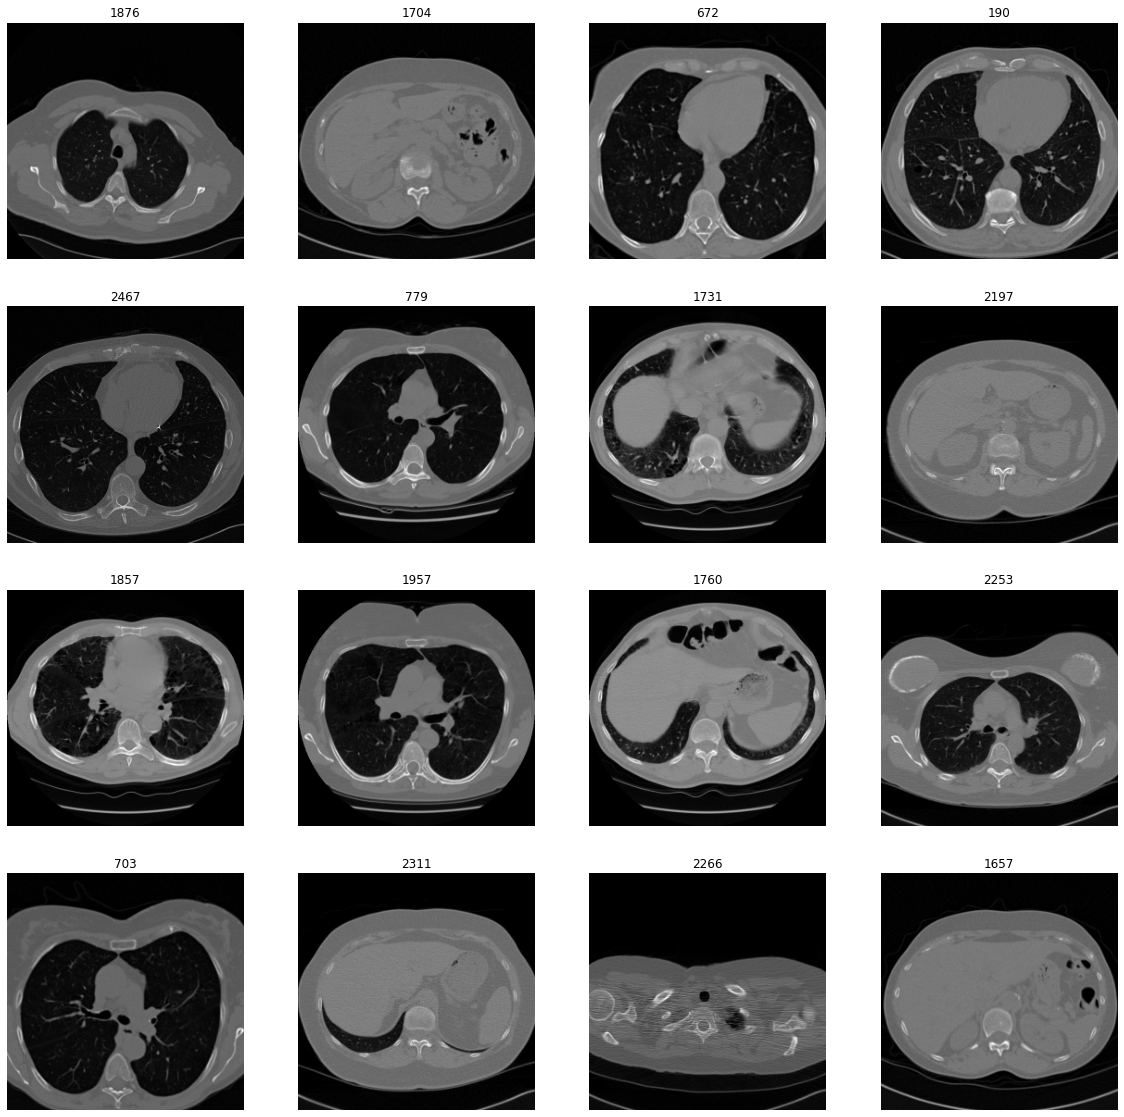

In [4]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(X_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(X_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

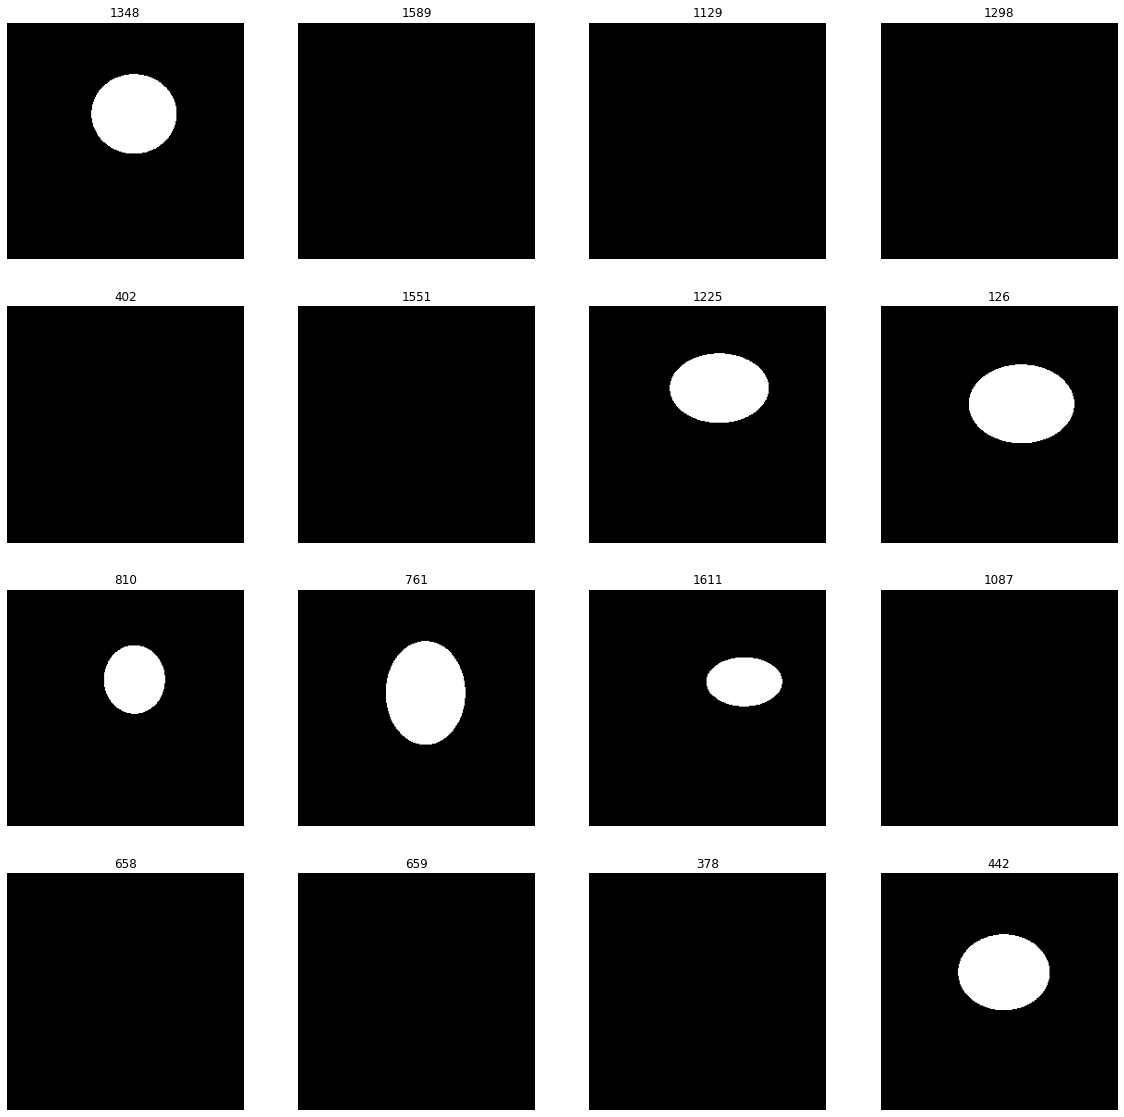

In [5]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(Y_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(Y_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

In [6]:
!pip install pydicom

In [7]:
import pydicom as dicom
from pydicom.data import get_testdata_file
#plt.imshow(pixel_array_numpy,cmap=plt.cm.bone)

In [8]:
TRAIN_PATH ='../input/ct-heart-segmentation/data/test/'
X_test=[]
for folder in tqdm(os.listdir(TRAIN_PATH)):
    files=gb.glob(TRAIN_PATH+folder+'/'+str(os.listdir(TRAIN_PATH+'/'+folder)[0])+'/*.dcm')
    for file in files :
        ds = dicom.dcmread(file)
        img = ds.pixel_array
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) 
        X_test.append(list(img))

100%|██████████| 6/6 [00:03<00:00,  1.85it/s]


In [9]:
X_test=np.array(X_test)

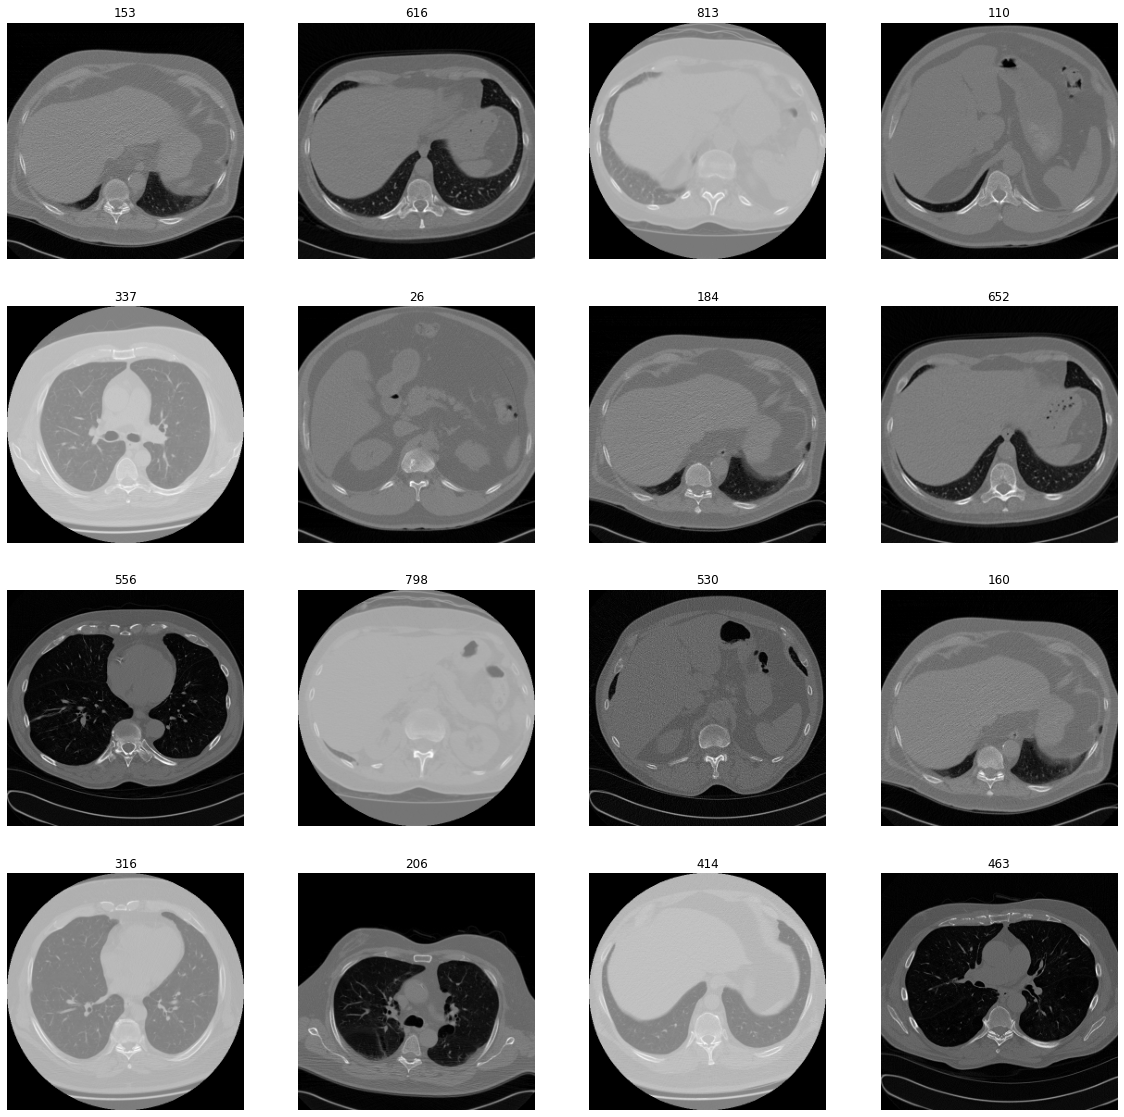

In [10]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(X_test),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(X_test[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

In [11]:
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2D , MaxPooling2D ,concatenate ,Input ,Dropout ,Conv2DTranspose
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

2021-10-07 11:55:46.441101: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [12]:
def unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c8)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    model.summary()
    
    return model

In [13]:
model=unet(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

2021-10-07 11:56:13.756357: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-07 11:56:13.757446: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-07 11:56:13.784290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 11:56:13.784966: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-07 11:56:13.785028: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-07 11:56:13.787427: I tensorflow/stream_executor/platform/def

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

In [14]:
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [15]:
history=model.fit(X_train,Y_train,validation_split=0.1,batch_size=32,steps_per_epoch=len(X_train)//32,epochs=10,
                 callbacks=callback,verbose=1)

2021-10-07 11:56:44.206850: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-07 11:56:44.207863: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000175000 Hz


Epoch 1/10


2021-10-07 11:56:45.420191: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-10-07 11:56:46.659466: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-07 11:56:46.899232: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


79/79 [==============================] - 30s 306ms/step - loss: 0.4868 - accuracy: 0.9679 - val_loss: 0.4352 - val_accuracy: 0.9718

Epoch 00001: val_loss improved from inf to 0.43516, saving model to model.hdf5
Epoch 2/10
79/79 [==============================] - 21s 260ms/step - loss: 0.4835 - accuracy: 0.9687 - val_loss: 0.4352 - val_accuracy: 0.9718

Epoch 00002: val_loss did not improve from 0.43516
Epoch 3/10
79/79 [==============================] - 21s 260ms/step - loss: 0.4808 - accuracy: 0.9688 - val_loss: 0.4352 - val_accuracy: 0.9718

Epoch 00003: val_loss did not improve from 0.43516
Epoch 4/10
79/79 [==============================] - 21s 260ms/step - loss: 0.4800 - accuracy: 0.9689 - val_loss: 0.4352 - val_accuracy: 0.9718

Epoch 00004: val_loss did not improve from 0.43516
Epoch 5/10
79/79 [==============================] - 21s 260ms/step - loss: 0.4713 - accuracy: 0.9694 - val_loss: 0.4352 - val_accuracy: 0.9718

Epoch 00005: val_loss did not improve from 0.43516
Epoch 6/

In [16]:
y_pred=model.predict(X_train)

In [17]:
y_pred_p=(y_pred > 0.5).astype(np.uint8)

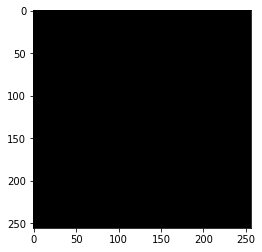

In [18]:
plt.imshow(y_pred_p[0],cmap='gray')